### Bootstrap

Bootstrap es una idea loca que surgió en los 80's que consiste en reaamplear con remplazo


In [1]:
# Importar liberias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Procedimiento: bootstrap resampling

1- Crea muchas muestras con remplazo y obten una metrica (promedio, desviación, AUC, lo que sea)

2- Guarda esa métrica en una lista

3- Esa lista te dará la distribución real de la variable aleatoria




## Aplicación : Intervalos de confianza para las market betas

In [2]:
# Get tickers
import yfinance as yf
tickers = ['VTI', 'AMZN', 'AAPL']
start_date = '2015-01-01'

# Descargar precios y graficar
St = yf.download(tickers, start=start_date)['Adj Close']

returns = St.pct_change().dropna()
returns.head()

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,AMZN,VTI
Date,,,
2015-01-05,-0.028171,-0.020517,-0.017183
2015-01-06,0.000094,-0.022833,-0.009798
2015-01-07,0.014022,0.010600,0.011933
2015-01-08,0.038422,0.006836,0.017640
2015-01-09,0.001073,-0.011749,-0.008290




Calcular beta con una regresión:
$$r_{vgt} = \beta_o + \beta_1 * r_{vti}$$

In [3]:
# Calcular beta del activo
from sklearn.linear_model import LinearRegression

X = returns[["VTI"]]
y = returns[["AAPL"]]

model = LinearRegression()

model.fit(X, y)
predictions = model.predict

model.coef_[0][0]

1.1713805594770916

In [5]:
# Calcule bootstrap de las betas
betas = []
n_reps = 10000
for i in range(n_reps):
    flag_frame = returns.sample(len(returns), replace=True)
    model = LinearRegression()
    X = flag_frame[["VTI"]]
    y = flag_frame[["AAPL"]]
    model.fit(X, y)
    beta = model.coef_[0][0]
    betas.append(beta)

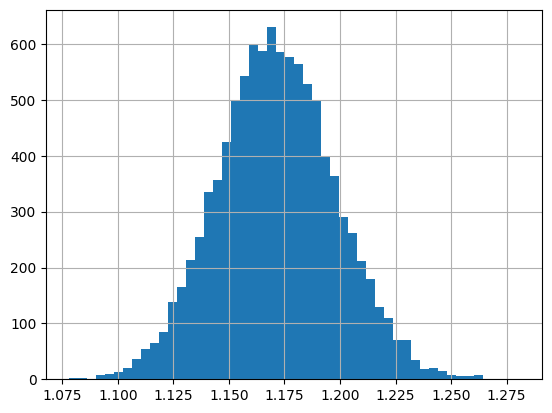

In [6]:
# Histograma de las betas
df_betas_aapl = pd.DataFrame()
df_betas_aapl["betas"] = betas

plt.hist(df_betas_aapl.betas, bins=50)
plt.grid()

¿Cuál es la probabilidad de que el beta sea menor a 0?

In [7]:
(df_betas_aapl.betas < 0).mean()

0.0

Probabilidad mayor a 1.2

In [8]:
(df_betas_aapl.betas > 1.2).mean()

0.1411

¿Cuál es la probabilidad de que el beta sea menor a 1?

In [9]:
(df_betas_aapl.betas < 1).mean()

0.0

Probabilidad que la beta sea mayor a 1.1

In [10]:
(df_betas_aapl.betas > 1.1).mean()

0.9969

## Con las betas anteriores, calcula el CAPM


rf = 4%

mercado = 9%

$$E[r_i] = rf + \beta * (E[m] - rf) $$

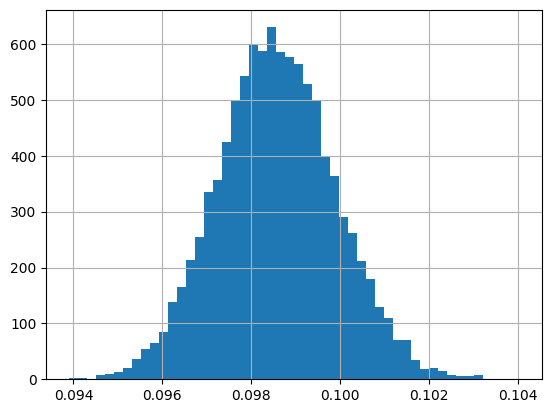

In [12]:
# Simula el CAPM con todas las betas del bootstrap
rf = 0.04
rm = 0.09

df_betas_aapl["capm"] = rf + df_betas_aapl.betas * (rm - rf)

plt.hist(df_betas_aapl.capm, bins=50)
plt.grid()

In [14]:
# Probabilidad de rendimiento esperado menor a 9%
(df_betas_aapl.capm < 0.09).mean()

0.0

In [15]:
# Probabilidad de rendimiento esperado menor a 10%
(df_betas_aapl.capm < 0.1).mean()

0.8589

In [17]:
(df_betas_aapl.capm > 0.095).mean()

0.9969

### Mezclando dos simulaciones

In [21]:
import random

def get_rf():
    rf = random.choice([0.01, 0.02, 0.03, 0.04, 0.05])
    return rf

def get_rm():
    rm = random.choice([0.06, 0.07, 0.08, 0.09])
    return rm
def get_betas():
    beta = random.choice(betas)
    return beta

rf_example = get_rf()
rm_example = get_rm()
beta_example = get_betas()

capm_example = rf_example + beta_example * (rm_example - rf_example)
capm_example

0.07480117964709983

In [27]:
capm_simulado = []
for i in range (10000):
    rf_example = get_rf()
    rm_example = get_rm()
    beta_example = get_betas()

    capm_example = rf_example + beta_example * (rm_example - rf_example)
    capm_simulado.append(capm_example)

In [28]:
df_capm = pd.DataFrame()
df_capm["capm"] = capm_simulado

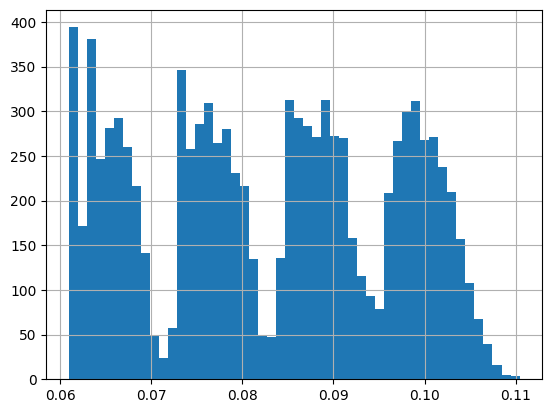

In [29]:
plt.hist(df_capm.capm, bins=50)
plt.grid()

In [30]:
(df_capm.capm > 0.08).mean()

0.5449

In [31]:
(df_capm.capm > 0.1).mean()

0.1259

### ¿Qué tan buena es la beta para escoger acciones?

#### ¿Será que lo que importa en realidad es la beta que tiene un activo?

Es decir, ¿si el mercado funciona así?

- *Lo único que importa es el riesgo*
- *Más riesgo es más rendimiento y el riesgo tiene que ver con el riesgo de mercado*


In [32]:
# Calcular beta del activo
X = returns[["VTI"]]
y = returns[["AMZN"]]
model = LinearRegression().fit(X, y)

model.coef_[0][0]

1.1155989649361115

In [33]:
# Prediiga usando el modelo
predicciones = model.predict(X)

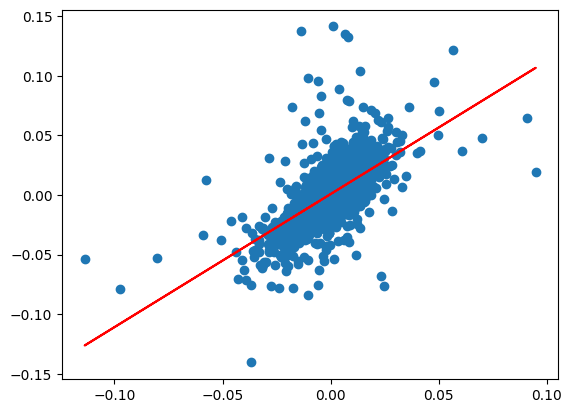

In [34]:
# Grafique regresion
plt.scatter(X, y)
plt.plot(X, predicciones, color="red")

$$ R^2 = \frac{Var(x_{mean}) - Var(x_{model})}{Var(x_{model})} $$

In [35]:
# Calcule el R2 con sklearn
from sklearn.metrics import r2_score

r2_score(y_true=y, y_pred=predicciones)

0.3813893745367428

In [37]:
# Doble bootstrap, betas y R2
# Calcule bootstrap de las betas
n = 10000
r2 = []
for i in range(n):
    flag_frame = returns.sample(len(returns), replace=True)
    X = flag_frame[["VTI"]]
    y = flag_frame[["AAPL"]]
    model = LinearRegression().fit(X, y)
    predicciones = model.predict(X)
    flag_r2 = r2_score(y_true=y, y_pred=predicciones)
    r2.append(flag_r2)

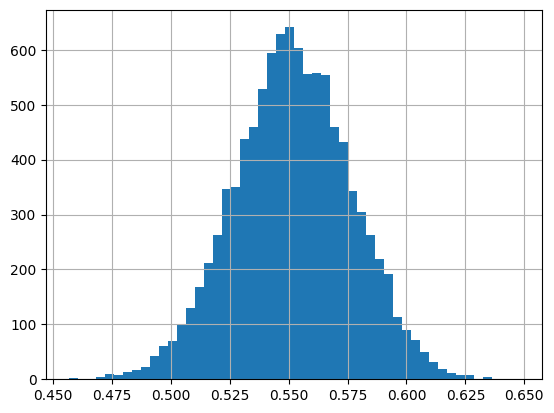

In [38]:
# Histograma del R2
plt.hist(r2, bins=50)
plt.grid()

### Probabilidad de que el 60% de la variación este explicado por el modelo

In [39]:
df_r2 = pd.DataFrame({
    "r2": r2
})

(df_r2.r2 > 0.6).mean()

0.0255

### Probabilidad de que el 45% de la variación este explicado por el modelo

# ¿Cuál sería la beta de un portafolio de 50% Amazon, 50% Apple?

In [40]:
# Crear portafolio
returns["portafolio"] = 0.5 * returns.AAPL + 0.5 * returns.AMZN

In [42]:
model = LinearRegression()
X = returns[["VTI"]]
y = returns[["portafolio"]]

model.fit(X, y)
model.coef_[0][0]

1.143489762206601

In [43]:
predicciones = model.predict(X)
r2_score(y_pred=predicciones, y_true=y)

0.5833174698984918

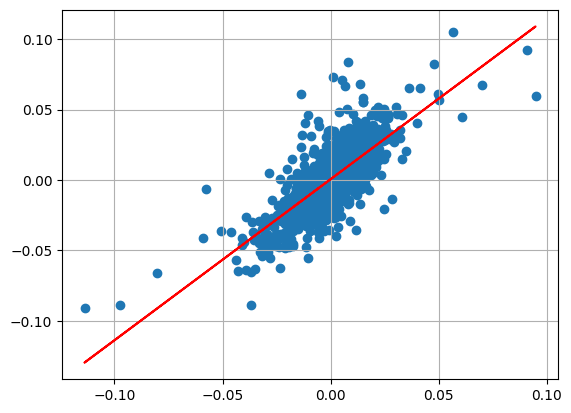

In [45]:
# Grafique el modelo
plt.scatter(X, y)
plt.plot(X, predicciones, color="red")
plt.grid()

In [46]:
n = 10000
r2 = []
betas = []
for i in range(n):
    flag_frame = returns.sample(len(returns), replace=True)
    X = flag_frame[["VTI"]]
    y = flag_frame[["portafolio"]]
    model = LinearRegression().fit(X, y)
    predicciones = model.predict(X)

    flag_r2 = r2_score(y_true=y, y_pred=predicciones)
    r2.append(flag_r2)

    flag_beta = model.coef_[0][0]
    betas.append(flag_beta)

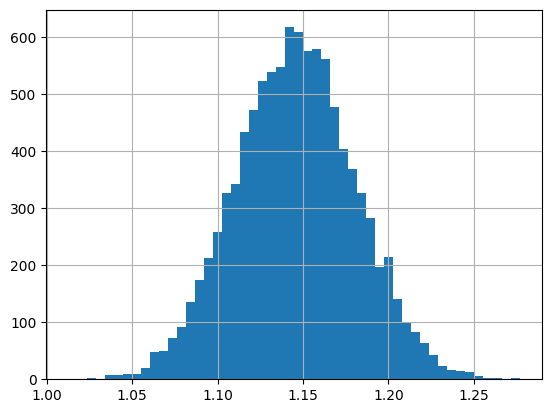

In [47]:
plt.hist(betas, bins=50)
plt.grid()

In [ ]:
# Probabiliad beta > 1.1

np.mean(df.betas > 1.1)

0.8886666666666667

# ¿Cuál sería el R2?

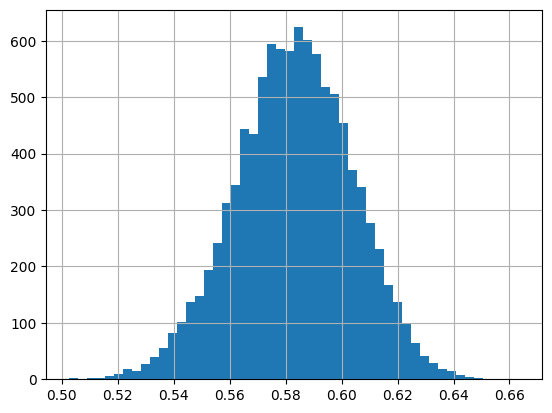

In [48]:
# Calcular R2
plt.hist(r2, bins=50)
plt.grid()

# Pregunta: ¿qué creen que pase con el R2 a medida que agregamos más activos a un portafolio?